<h1><font color='navy'>Skup podataka i vizualizacija</font><h1>

<h2><font color='navy'>Cora</font><h2>

Skup podataka sa kojim ćemo raditi je jedan od najpopularnijih grafovskih skupova podataka i naziva se **Cora** - to je poznati skup koji se sastoji od 2708 naučnih radova/publikacija vezanih za mašinsko učenje koji su klasifikovani u jednu od 7 kategorija. To su:
- Reinforcement Learning
- Neural Networks
- Case Based
- Genetic Algorithms
- Probabilistic Methods
- Rule Learning
- Theory

Svaka <b>publikacija</b> u skupu podataka je opisana vektorima reči sa vrednošću 0/1 koji ukazuje na odsustvo/prisustvo odgovarajuće <b>reči</b> iz rečnika. Rečnik se sastoji od 1433 jedinstvenih reči. Između publikacija, nalazi se mreža koja spaja određene radove i sastoji se od 5429 <b>linkova</b>.

U ovom skupu podataka <b>čvorovi</b> odgovaraju dokumentima, a ivice neusmerenim citatima. Karakteristike čvorova odgovaraju elementima grupe reči iz dokumenata.

Na sledećoj slici predstavljamo vizuelno izgled ovog skupa podataka gde veličina čvora zavisi od broja ulaznih/izlaznih ivica. Debljina ivice predstavlja koliko je "popularna" tj. povezana ta ivica. U skupu podataka imamo 7 različitih oblasti naučnih radova koji su predstavljeni sa 7 različitih boja na grafiku.

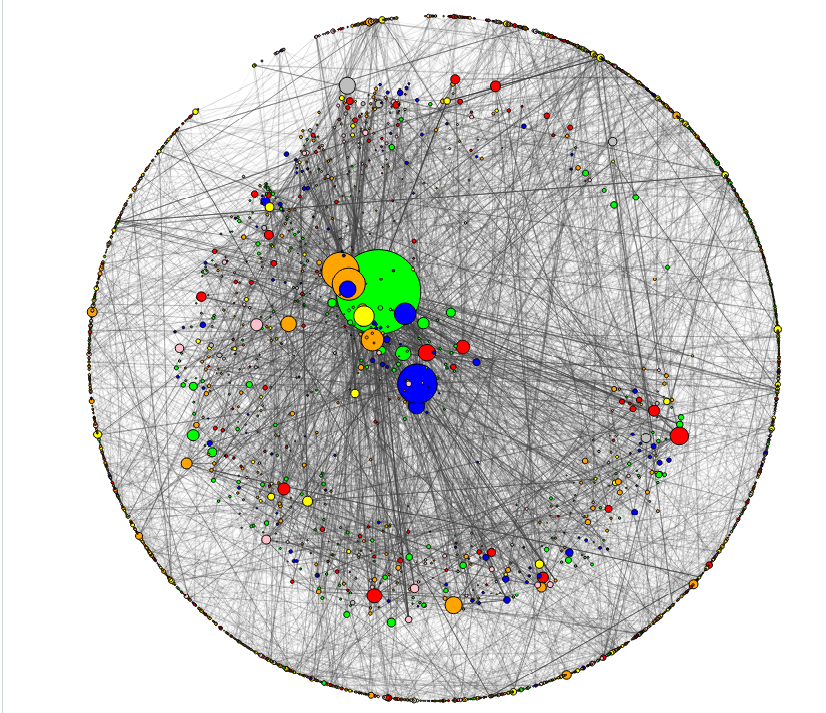

In [1]:
from IPython.display import Image
Image("pictures./vizualizacija.png")

<h2><font color='navy'>Vizualizacija</font><h2>

Za potrebe boljeg razumevanja skupa podataka, najpre ćemo učitati podatke i vizualizovati ih.

In [2]:
import pickle
import os
import utils

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp
import numpy as np

# Deep learning related imports
import torch

Definišemo funkcije za učitavanje podataka i funkciju build_edge_index koja pravi jedinstvene parove povezanih čvorova (članaka).

In [3]:
# function for data loading

def pickle_read(path): 
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

In [4]:
# the output value is a set of connected nodes represented as unique ordered pairs 

def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:

            if (src_node, trg_node) not in seen_edges: 
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))


    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

Podaci se učitavaju iz tri fajla. U jednom se nalaze atributi čvorova, u drugom labele čvorova i u trećem je matrica povezanosti čvorova.

In [5]:
CORA_PATH = "data"

node_features_csr = pickle_read(os.path.join(CORA_PATH, "node_features.csr"))
node_labels_npy = pickle_read(os.path.join(CORA_PATH, "node_labels.npy"))
adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, "adjacency_list.dict"))

num_of_nodes = len(node_labels_npy) # number of nodes

Izlaz funkcije build_edge_index predstavlja matricu od 2 vrste: u prvoj vrsti su smešteni početni čvorovi, a u drugoj svi čvorovi sa kojom su oni spojeni. 

In [6]:
topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True) 

In [7]:
topology

array([[   0,    0,    0, ..., 2705, 2706, 2707],
       [ 633, 1862, 2582, ..., 2705, 2706, 2707]])

In [8]:
topology.shape 

(2, 13264)

Naš graf ima ukupno 13264 ivica među čvorovima.

Prikazaćemo 2 grafika:
- Broj čvorova sa koliko je povezan (linkovan) svaki čvor
- Grafik učestalosti broja ivica po čvorovima

In [9]:
# input values are the number of nodes and set of connected nodes
def plot_in_out_degree_distributions(edge_index, num_of_nodes):
    
    # we have an undirected graph so we only count how many nodes each node is connected to
    # for each node we want to keep the number of nodes to which it is connected
    edge_degrees = np.zeros(num_of_nodes, dtype=int)
    
    num_of_edges = edge_index.shape[1] 
    for cnt in range(num_of_edges):
        first_node_id = edge_index[0, cnt] # index of the first node 
        edge_degrees[first_node_id] += 1  # we increase the number of nodes to which the node is associated with

    hist = np.zeros(np.max(edge_degrees)+1) # for each number of edges we count how many nodes there are with that number of edges
    for edge_degree in edge_degrees:
        hist[edge_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)
    fig.subplots_adjust(hspace=0.6)

    # a graph representing how many nodes each node is connected to
    plt.subplot(311)
    plt.plot(edge_degrees, color='purple')
    plt.xlabel('node id'); plt.ylabel('edge-degree count'); plt.title('Edge degree for different node ids')
    
    # a graph representing the frequency of the number of edges per node
    plt.subplot(312)
    plt.plot(hist, color='green')
    plt.xlabel('node degree')
    plt.ylabel(' nodes for a given degree') 
    plt.title(f'Node degree distribution for cora dataset')
    plt.xticks(np.arange(0, len(hist), 10.0))

    plt.grid(True)
    plt.show()

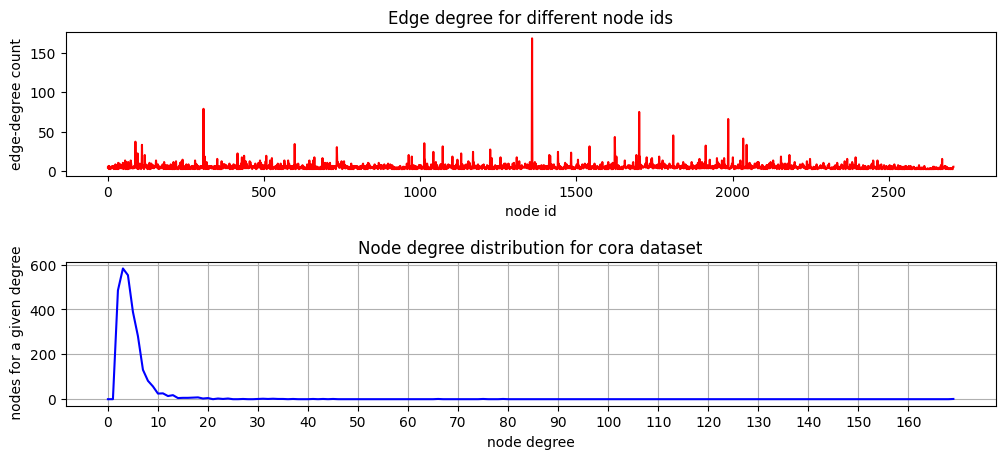

In [10]:
plot_in_out_degree_distributions(topology, num_of_nodes)

<blockquote>Iz priloženih grafika zaključujemo da je većina čvorova povezana sa $< 50$ drugih čvorova, dok ih je svega par povezano sa više. Jedan čvor se izdvaja sa $> 150$ linkova, što možemo na prvoj slici povezati sa čvorom koji je najveće veličine.</blockquote>